In [3]:
% matplotlib inline

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import scipy.io as sio

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [6]:
# import data

#maxlon = 300
#minlon = 179

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
#Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok2 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo2_vSept16.csv', sep = ',')
Tok2['density'] = sw.rho(Tok2['S'].values,Tok2['T'].values,0)

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
#Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
#Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


In [7]:
# load the satellite NPP data

fname = '/Users/sclayton/Google Drive/work/kuroshio_productivity/data/satellite/vgpm/vgpm.2011129.all.xyz'
npp_may11 = pd.read_csv(fname, sep = ' ')

fname = '/Users/sclayton/Google Drive/work/kuroshio_productivity/data/satellite/vgpm/vgpm.2011137.all.xyz'
npp_may11b = pd.read_csv(fname, sep = ' ')

lon = (npp_may11['lon']).values # longitude
lat = (npp_may11['lat']).values # latitude
npp1 = (npp_may11['value']).values # npp
npp2 = (npp_may11b['value']).values # npp

# reshape the data to a 2160x4320 grid
ny = 2160
nx = 4320

LON = lon.reshape(ny,nx)
LAT = lat.reshape(ny,nx)
NPP_may1 = npp1.reshape(ny,nx)
NPP_may2 = npp2.reshape(ny,nx)

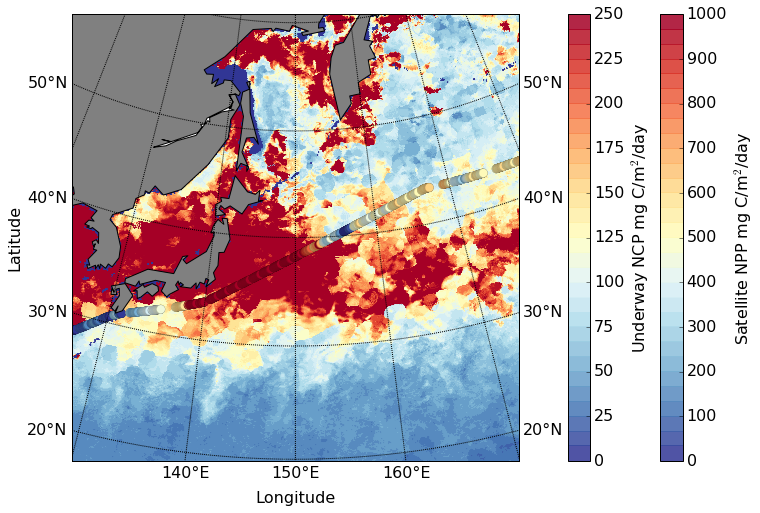

In [34]:
fig2 = plt.figure(2, figsize=(13, 8), dpi = 600)
palette = plt.get_cmap('RdYlBu_r', 30)
m = Basemap(width=4500000,height=4500000,projection='lcc',
            resolution='c',lat_1=30.,lat_2=60.,lat_0=40.,lon_0=150.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(LON, LAT)
#m.plot(xm,ym,'.r')
cax1 = m.pcolormesh(xm, ym, NPP_may1, shading='flat', alpha=.85,lw=0, vmin = 0, vmax = 1000, cmap = palette)

xm, ym = m((Tok1['Lon']).values,(Tok1['Lat']).values)
cax2 = m.scatter(xm, ym, s=75, c=(Tok1['Air-sea flux'].values*(12/1.4)), alpha=.85,lw=0.1, vmin = 0, vmax = 250, cmap = palette)

m.drawparallels(np.arange(10,90,10),labels=[1,1,0,1], fontsize=16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Longitude', fontsize = 16, labelpad = 30)
plt.ylabel('Latitude', fontsize = 16, labelpad = 50)

cb1 = plt.colorbar(cax1, pad = 0.0)
cb1.ax.tick_params(labelsize=16)
cb1.set_label('Satellite NPP mg C/m$^2$/day', fontsize = 16)

cb2 = plt.colorbar(cax2, pad = 0.08)
cb2.ax.tick_params(labelsize=16)
cb2.set_label('Underway NCP mg C/m$^2$/day', fontsize = 16)
plt.show()

In [46]:
# pull out the satellite NPP data to line up with underway NCP

ncp = Tok1['Air-sea flux'].values

ncp_track = []
npp_track = []
new_lat = []
spacing = 0.0833

x = lon
y = lat

xnew = Tok1['Lon'].values
ynew = Tok1['Lat'].values

x = np.arange(130, 171, spacing)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    
    # now need to find NPP value to coincide with NCP
    ll = np.squeeze(np.where((lat>=(l - (spacing*0.5))) & (lat<=(l + (spacing*0.5)))))
    mm = np.squeeze(np.where((lon>=(x[n] - (spacing*0.5))) & (lon<(x[n] + (spacing*0.5)))))
   
    ss = np.asscalar(np.mean(np.squeeze(NPP_may1[mm,ll])))

    if np.isfinite(m) & np.isfinite(l):
        ncp_track.append(m)
        new_lat.append(l)
        npp_track.append(ss)
    else:
        ncp_track.append(np.nan)
        new_lat.append(np.nan)
        npp_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['npp'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtabT1 = dtab.dropna()

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2160,) (4320,) 

9331200